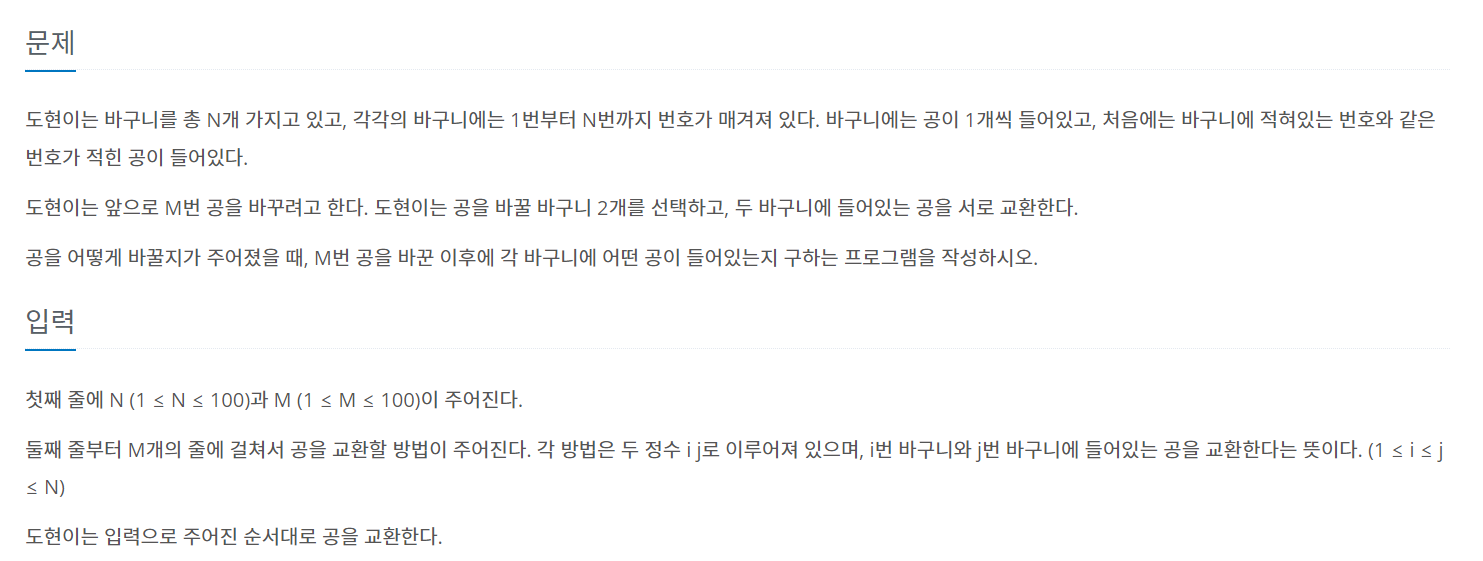
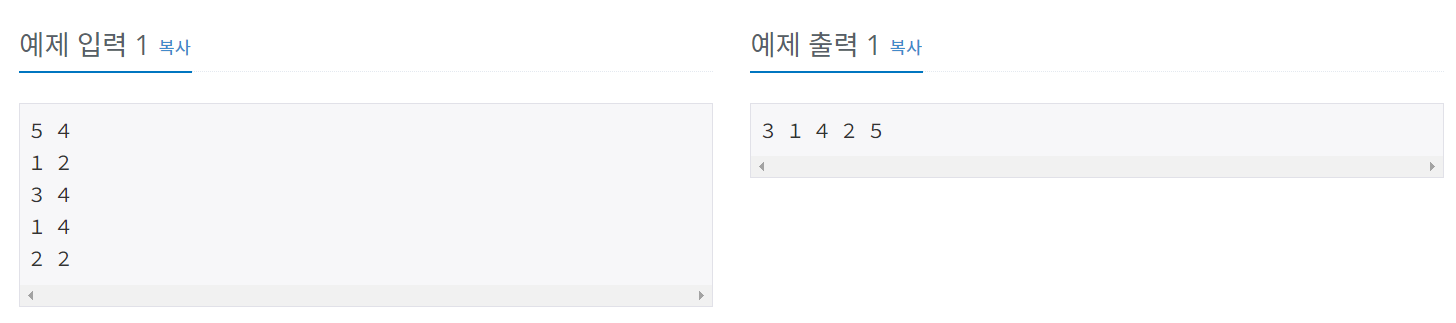

In [ ]:
  # N, M  입력
N,M = map(int, input().split())

# N개의 바구니 생성
N_ls = []
for n in range(N):
    N_ls.append(n+1)

# M번의 바구니 위치 교환
for _ in range(M):
    i, j = map(int, input().split())
    i -= 1
    j -= 1
    k = N_ls[i]
    N_ls[i] = N_ls[j]
    N_ls[j] = k
    
for g in N_ls:
    print(g, end=" ")


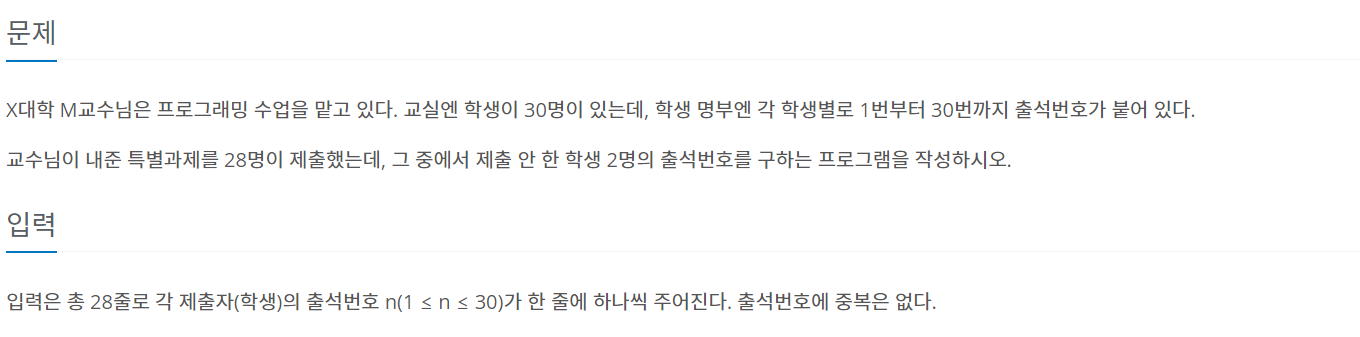
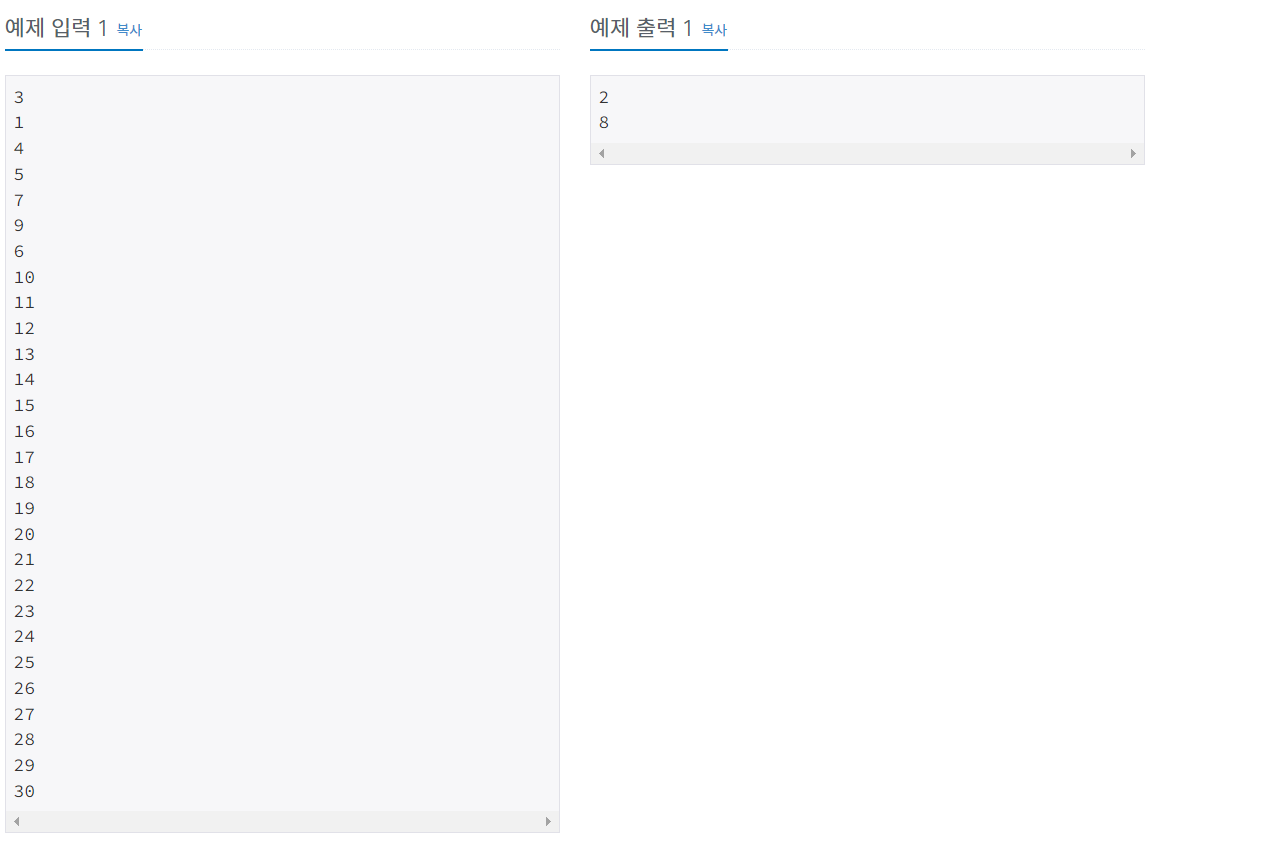

In [3]:
# 출석부 만들기
student_ls = []
for i in range(1,31):
    student_ls.append(i)

# 출석한 학생 리스트 만들기 
check_ls = []
for _ in range(28):
    check_ls.append(int(input()))

# 두개의 리스트 비교 
for k in student_ls:
    if k not in check_ls:
        print(k)

2
8


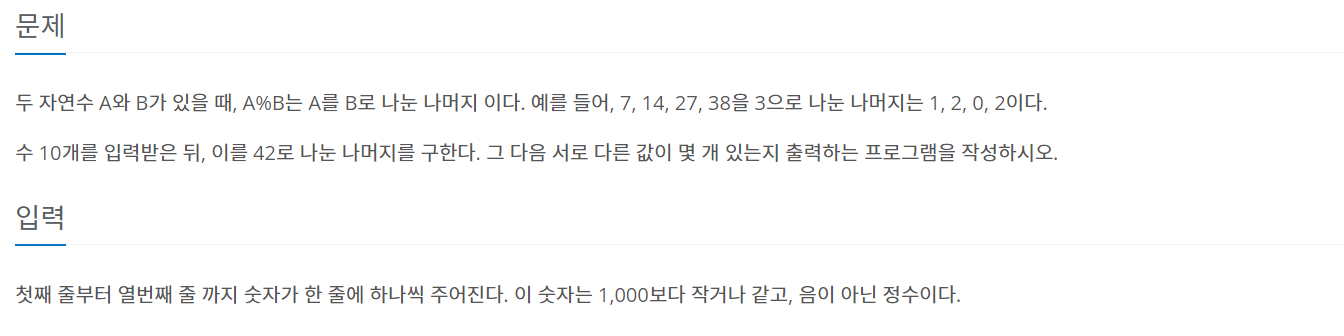
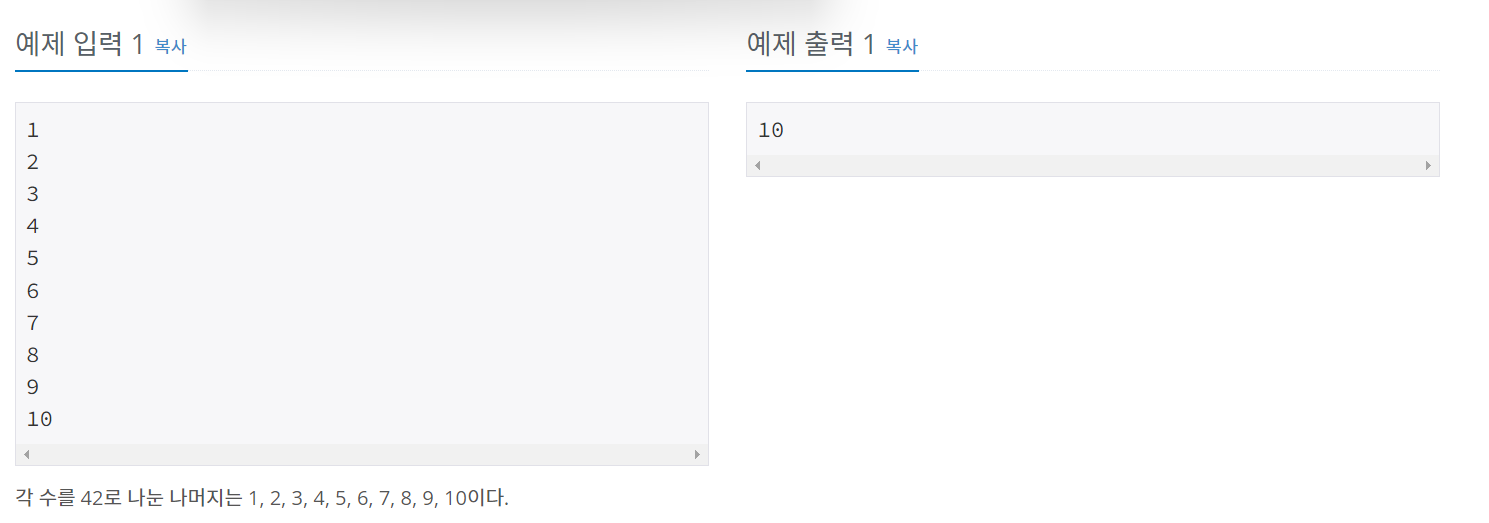


In [ ]:
ls = []
for _ in range(10):
    i = int(input())
    ls.append(i % 42)

print(len(set(ls)))

In [6]:
# 힌트
ls = [1,23,4,3,4,5,5,6,6,6,66,6,7,8,8,8,9]
ls_1 = [12,3,4,4,55,6,6,6,7,8,8,9,9,9,0,00]
print(set(ls))
print(set(ls_1))
print(set(ls) & set(ls_1))
print(set(ls) | set(ls_1))

{1, 66, 3, 4, 5, 6, 7, 8, 9, 23}
{0, 3, 4, 6, 7, 8, 9, 12, 55}
{3, 4, 6, 7, 8, 9}
{0, 1, 66, 3, 4, 5, 6, 7, 8, 9, 12, 23, 55}


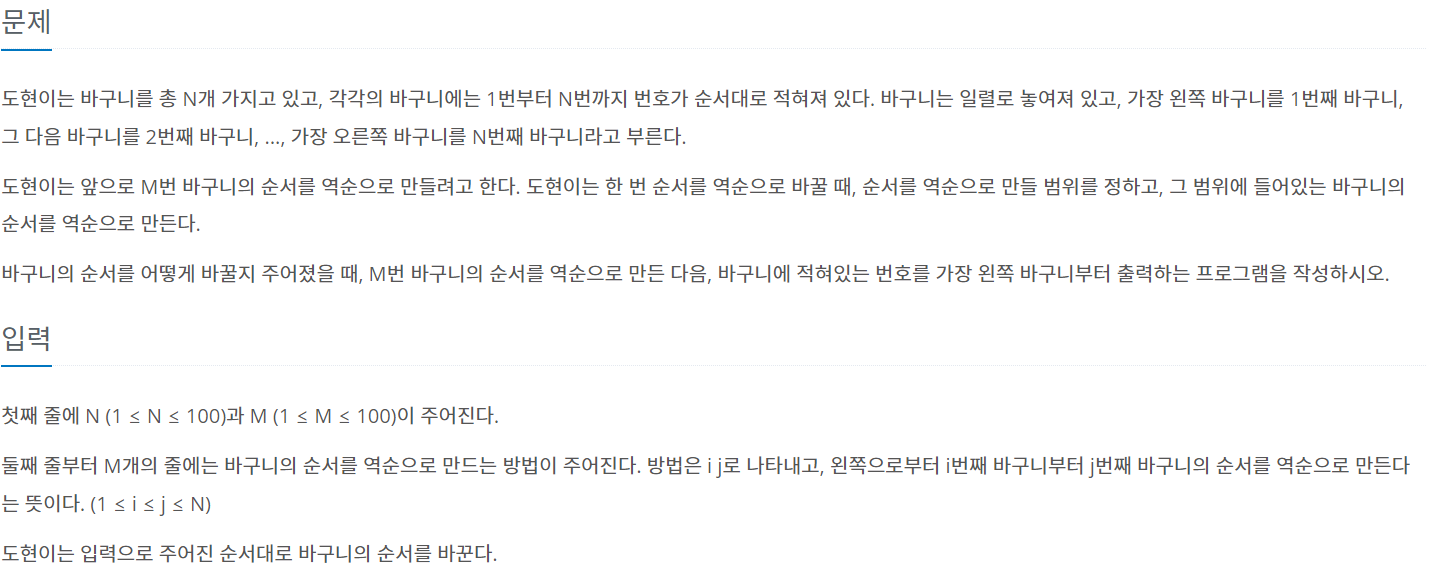
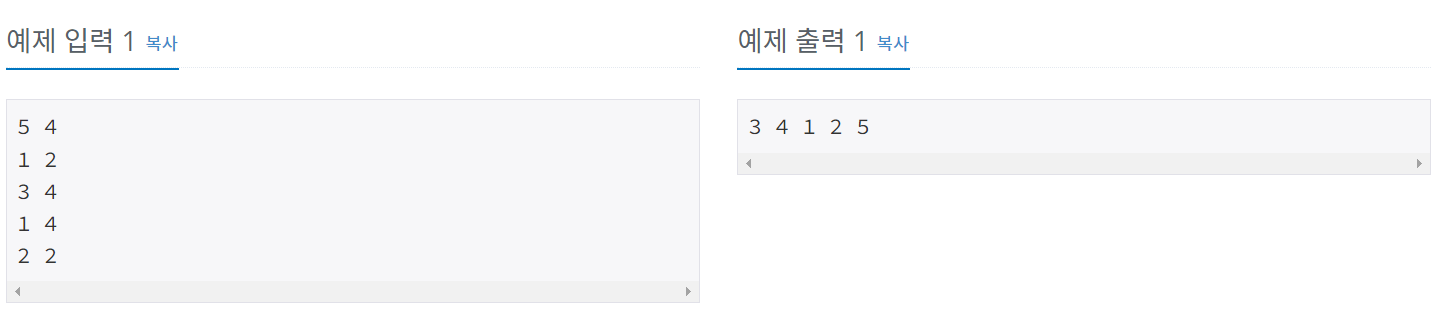

In [ ]:
# N, M  입력
N,M = map(int, input().split())

# N개의 바구니 생성
N_ls =  [n+1 for n in range(N)]


# M번의 바구니 위치 교환
for _ in range(M):
    i, j = map(int, input().split())
    i -= 1
    chan_ls = N_ls[i:j]
    chan_ls.reverse()
    N_ls[i:j] = chan_ls
    
for g in N_ls:
    print(g, end=" ")

In [105]:
#  힌트
ls = [1,2,3,4,5,6,6,7,7,8]
a = ls[2:5]
a.reverse()
ls[2:5] =a
print(ls)
print(ls[2:5], ls[2], ls[5])

[1, 2, 5, 4, 3, 6, 6, 7, 7, 8]
[5, 4, 3] 5 6


--- 

In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

fold = KFold(n_splits=5, shuffle=True, random_state=156)

lr_rg = LogisticRegression()
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()


In [9]:
#  데이터 로드
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

#  데이터 합치기
df = pd.concat([train, test], axis=0)

# 결측치 대체
df.fillna(0, inplace=True)

# 레이블 int화
df["Survived"] = df["Survived"].astype("int")

# 수치형 데이터만 추출
df = df.select_dtypes(exclude="float")
df = df.select_dtypes(exclude="object")

# 레이블과 피쳐 분리
x = df.drop(columns="Survived", axis=1)
y = df["Survived"]


# 트레인 테스트 분리 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=15)


train = pd.concat([x_train, y_train], axis=1)


In [10]:
model_ls = [lr_rg, dt_clf, rf_clf, xgb]
average_accuracy = []  

for model in model_ls:
    fold_accuracy = []  # 각 폴드에서의 정확도를 저장할 리스트
    print(model.__class__.__name__, '모델 시작')
    for i, (train_index, test_index) in enumerate(fold.split(train)):
        print("Fold 횟수:", i+1)
        feature = x_train.iloc[train_index]
        target = y_train.iloc[train_index]
        test_predioct = x_train.iloc[test_index] 
        test_test =  y_train.iloc[test_index]
        
        clf = model.fit(feature, target)
        pred = clf.predict(test_predioct)
        
        acc = accuracy_score(test_test, pred)
        fold_accuracy.append(acc)  # 폴드 정확도를 리스트에 추가
    
    avg_acc = sum(fold_accuracy) / len(fold_accuracy)  # 폴드 정확도의 평균 계산
    average_accuracy.append(avg_acc)  # 모델별 평균 정확도를 리스트에 추가

# 모델별 평균 정확도 출력
for model, avg_acc in zip(model_ls, average_accuracy):
    print(f"{model.__class__.__name__}의 평균 정확도:", avg_acc)


LogisticRegression 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5
DecisionTreeClassifier 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5
RandomForestClassifier 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5
XGBClassifier 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5
LogisticRegression의 평균 정확도: 0.7536021872863977
DecisionTreeClassifier의 평균 정확도: 0.7459239006607428
RandomForestClassifier의 평균 정확도: 0.7421189336978811
XGBClassifier의 평균 정확도: 0.7430530872636136


In [42]:
# 사용할 모델 ls
model_ls = [lr_rg, dt_clf, rf_clf, xgb]

# 결과를 담을 딕셔너리
rdict={'model':[], 'acc':[],'precision':[],'recall':[],'f1_score':[], 'AUC':[]}


# 스태킹 모델을 위한 test 데이터 만들기
test_list = []
for model in model_ls:
    clf = model.fit(x_train,y_train)
    pred_stk = clf.predict(x_test)
    test_list.append(pred_stk)
x_test_stk = pd.DataFrame(test_list).T
x_test_stk.columns = ["result_lr","result_dt", "result_rf", "result_xgb"]
y_test.reset_index(drop=True,inplace=True)
x_test_stk["y_test"] = y_test


# 스태킹 모델을 위한 train 데이터 만들기
fold_list = []  # 메타 데이터를 담을 ls
df_pred = pd.DataFrame() # ls담긴 데이터를 데이터프레임으로 만들기 위해 빈 데이터프레임 생성
for model in model_ls:
    pred_list = []
    print(model.__class__.__name__, '모델 시작')
    for count_i, (train_index, test_index) in enumerate(fold.split(train)):
        print("Fold 횟수:", count_i+1)
        feature = x_train.iloc[train_index]
        target = y_train.iloc[train_index]
        test_predioct = x_train.iloc[test_index]
        clf = model.fit(feature, target) 
        pred = clf.predict(test_predioct) 
        
        pred_list.append(pred)

    df_pred["result"] = pd.DataFrame([arr for sublist in pred_list for arr in sublist])
    fold_list.append(df_pred["result"])

df_stk = pd.DataFrame(fold_list).T
df_stk.columns = ["result_lr","result_dt", "result_rf", "result_xgb"]        
y_train.reset_index(drop=True,inplace=True)
df_stk["target"] = y_train

# 메타 데이터 학습을 위한 x_train, y_train 정의
x_train_stk = df_stk.drop(columns="target", axis=1)
y_train_stk = df_stk["target"]

# lgbm이용해서 메타 데이터 학습 후 예측
lgbm.fit(x_train_stk, y_train_stk)
pred_stk = lgbm.predict(x_test_stk.drop(columns="y_test", axis=1))

rdict['model'].append("LGBMClassifier"); 
rdict['acc'].append(accuracy_score(np.array(x_test_stk["y_test"]),pred_stk))
rdict['precision'].append(precision_score(np.array(x_test_stk["y_test"]),pred_stk))
rdict['recall'].append(recall_score(np.array(x_test_stk["y_test"]),pred_stk))
rdict['f1_score'].append(f1_score(np.array(x_test_stk["y_test"]),pred_stk))
rdict['AUC'].append(roc_auc_score(np.array(x_test_stk["y_test"]),pred_stk))
pd.DataFrame(rdict)


LogisticRegression 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5
DecisionTreeClassifier 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5
RandomForestClassifier 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5
XGBClassifier 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5


c:\Users\leeju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,acc,precision,recall,f1_score,AUC
0,LGBMClassifier,0.740458,0.0,0.0,0.0,0.5


In [11]:
def stacking_data_making(model):
    train_pred = np.zeros((x_train.shape[0], 1))
    test_pred = np.zeros((x_test.shape[0], 5))
    print(model.__class__.__name__, '모델 시작')

    for count_i, (train_index, test_index) in enumerate(fold.split(train)):
        print("Fold 횟수:", count_i+1)
        feature = x_train.iloc[train_index]
        target = y_train.iloc[train_index]
        test_predioct = x_train.iloc[test_index]

        model.fit(feature, target) 
        train_pred[test_index, :] = model.predict(test_predioct).reshape(-1,1)
        test_pred[:, count_i] = model.predict(x_test)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)  
    return train_pred, test_pred_mean


LR_train, LR_test = stacking_data_making(lr_rg)
DT_train, DT_test = stacking_data_making(dt_clf)
RF_train, RF_test = stacking_data_making(rf_clf)
xgb_train, xgb_test = stacking_data_making(xgb)



# 스태킹 모델을 위한 메타 데이터 생성
meta_train = np.concatenate((LR_train, DT_train, RF_train, xgb_train), axis=1)
meta_test = np.concatenate((LR_test, DT_test, RF_test, xgb_test), axis=1)

# 스태킹 모델 학습 및 예측
rdict={'model':[], 'acc':[],'precision':[],'recall':[],'f1_score':[], 'AUC':[]}

stacking_model = LGBMClassifier()
stacking_model.fit(meta_train, y_train)
pred_stacking = stacking_model.predict(meta_test)

rdict['model'].append("LGBMClassifier"); 
rdict['acc'].append(accuracy_score(y_test,pred_stacking))
rdict['precision'].append(precision_score(y_test,pred_stacking))
rdict['recall'].append(recall_score(y_test,pred_stacking))
rdict['f1_score'].append(f1_score(y_test,pred_stacking))
rdict['AUC'].append(roc_auc_score(y_test,pred_stacking))
pd.DataFrame(rdict)



LogisticRegression 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5
DecisionTreeClassifier 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5
RandomForestClassifier 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5
XGBClassifier 모델 시작
Fold 횟수: 1
Fold 횟수: 2
Fold 횟수: 3
Fold 횟수: 4
Fold 횟수: 5


,model,acc,precision,recall,f1_score,AUC
0,LGBMClassifier,0.740458,0.5,0.573529,0.534247,0.686249


---
# 리샘플링

In [8]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss, ClusterCentroids, EditedNearestNeighbours


In [14]:
def over(df, target, method='random', sampling_strategy=1.0):
    
    # 타겟 변수와 특성 변수를 분리
    X = df
    y = target
    
    if method == 'random':
        # RandomOverSampler 객체 생성, sampling_strategy 값 설정
        oversampler = RandomOverSampler(sampling_strategy=sampling_strategy)

    elif method == 'smote':
        # SMOTE 객체 생성, sampling_strategy 값 설정
        oversampler = SMOTE(sampling_strategy=sampling_strategy)

    elif method == 'adasyn':
        # adasyn 객체 생성, sampling_strategy 값 설정
        oversampler = ADASYN(sampling_strategy=sampling_strategy)

    elif method == 'Borderline-SMOTE':
        # Borderline-SMOTE 객체 생성, sampling_strategy 값 설정
        oversampler = BorderlineSMOTE(sampling_strategy=sampling_strategy)

    elif method == 'SMOTENC':
        # SMOTENC 객체 생성, sampling_strategy 값 설정
        oversampler = SMOTENC(sampling_strategy=sampling_strategy)

    
    # 오버샘플링 수행
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    # 오버샘플링된 데이터 프레임 생성
    df_over = pd.concat([X_resampled, y_resampled], axis=1)

    return df_over


In [5]:
def under(df, target, method='random', sampling_strategy=1.0):
    
    # 타겟 변수와 특성 변수를 분리
    X = df
    y = target

    if method == 'random':
        # RandomUnderSampler 객체 생성, sampling_strategy 값 설정
        undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy)

    elif method == 'tomek':
        # TomekLinks 객체 생성, sampling_strategy 값 설정
        undersampler = TomekLinks(sampling_strategy=sampling_strategy)

    elif method == 'NearMiss':
        # NearMiss 객체 생성, sampling_strategy 값 설정
        undersampler = NearMiss(sampling_strategy=sampling_strategy)

    elif method == 'cluster_centroids':
        # ClusterCentroids 객체 생성, sampling_strategy 값 설정
        undersampler = ClusterCentroids(sampling_strategy=sampling_strategy)

    elif method == 'edited_nn':
        # EditedNearestNeighbours 객체 생성, sampling_strategy 값 설정
        undersampler = EditedNearestNeighbours(sampling_strategy=sampling_strategy)

    # 언더샘플링 수행
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    # 언더샘플링된 데이터 프레임 생성
    df_under = pd.concat([X_resampled, y_resampled], axis=1)

    return df_under

In [12]:
y_train.value_counts(property)

Survived
0    0.7383
1    0.2617
Name: proportion, dtype: float64

In [15]:
train_over = over(x_train, y_train, sampling_strategy = 1)
train_over["Survived"].value_counts(property)

Survived
1    0.5
0    0.5
Name: proportion, dtype: float64

In [18]:
def evaluate_resampling_model(x_train, y_train, x_test, y_test, method, num_iterations=100, over_ratio = 0.5 ,under_ratio=0.5,random_state=None):
    

    # 모델 성능 저장을 위한 리스트
    score = {"accuracy_scores_mean" : [] ,"f1_scores_mean" :[], "recall_scores_mean" : [] , "precision_scores_mean" : [],  "auc_mean" : []}
    std_score = {"accuracy_scores_std" : [] ,"f1_scores_std" :[], "recall_scores_std" : [] , "precision_scores_std" : [],  "auc_std" : []}  

    recall_scores=[]
    accuracy_scores=[]
    f1_scores=[]
    precision_scores=[]
    auc_scores=[]
    
    
    # 랜덤샘플러 생성
    sampler_over = BorderlineSMOTE(sampling_strategy=over_ratio, random_state=random_state)
    sampler_under = RandomUnderSampler(sampling_strategy=under_ratio, random_state=random_state)

    

    # 랜덤 샘플링 반복 수행
    for i in range(num_iterations):
        
        x_train_over, y_train_over = sampler_over.fit_resample(x_train, y_train)
        x_test_under, y_test_under = sampler_under.fit_resample(x_test, y_test)

        if method == "Logistic":
            model = LogisticRegression().fit(x_train_over, y_train_over)
            y_pred = model.predict(x_test_under)
            y_pred_proba = model.predict_proba(x_test_under)[:,1].reshape(-1,1)

        if method == "Decision":
            model = DecisionTreeClassifier().fit(x_train_over, y_train_over)
            y_pred = model.predict(x_test_under)
            y_pred_proba = model.predict_proba(x_test_under)[:,1].reshape(-1,1)
        
        if method == "Random":
            model = RandomForestClassifier().fit(x_train_over, y_train_over)
            y_pred = model.predict(x_test_under)
            y_pred_proba = model.predict_proba(x_test_under)[:,1].reshape(-1,1)
        
        if method == "XGB":
            model = XGBClassifier().fit(x_train_over, y_train_over)
            y_pred = model.predict(x_test_under)
            y_pred_proba = model.predict_proba(x_test_under)[:,1].reshape(-1,1)
        
        #모델 성능 평가 
        accuracy = accuracy_score(y_test_under, y_pred)
        f1 = f1_score(y_test_under, y_pred)
        recall = recall_score(y_test_under, y_pred)
        precision = precision_score(y_test_under, y_pred)
        auc = roc_auc_score(y_test_under, y_pred_proba)
        
        # 리스트에 결과값 담아주기
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)
        auc_scores.append(auc)

    

    # 모델 성능 평균 및 표준편차 계산
    accuracy_mean = np.mean(accuracy_scores)
    f1_mean = np.mean(f1_scores)
    recall_mean = np.mean(recall_scores)
    precision_mean = np.mean(precision_scores)
    auc_scores_mean = np.mean(auc_scores)


    score["accuracy_scores_mean"].append(accuracy_mean)
    score["f1_scores_mean"].append(f1_mean)
    score["recall_scores_mean"].append(recall_mean)
    score["precision_scores_mean"].append(precision_mean)
    score["auc_mean"].append(auc_scores_mean)

    accuracy_std = np.std(accuracy_scores)
    f1_std = np.std(f1_scores)
    recall_std = np.std(recall_scores)
    precision_std = np.std(precision_scores)
    auc_scores_std = np.std(auc_scores)

    std_score["accuracy_scores_std"].append(accuracy_std)
    std_score["f1_scores_std"].append(f1_std)
    std_score["recall_scores_std"].append(recall_std)
    std_score["precision_scores_std"].append(precision_std)
    std_score["auc_std"].append(auc_scores_std)
    
    print(score)
    print(std_score)

evaluate_resampling_model(x_train, y_train, x_test, y_test, method = "Random", num_iterations=10, over_ratio = 0.5 ,under_ratio=0.5,random_state=None)

{'accuracy_scores_mean': [0.7196078431372549], 'f1_scores_mean': [0.541062712064291], 'recall_scores_mean': [0.49558823529411766], 'precision_scores_mean': [0.5963670028269151], 'auc_mean': [0.7917495674740485]}
{'accuracy_scores_std': [0.016666666666666673], 'f1_scores_std': [0.023345430224356666], 'recall_scores_std': [0.020849186586408563], 'precision_scores_std': [0.03309934119656907], 'auc_std': [0.011837430107902974]}
